In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [2]:
# Import and Organize Tree Sur

# Import tree survey data
data = geopandas.read_file('Data/Trees/2015 Street Tree Census - Tree Data/geo_export_f9cac9c3-66c4-45b6-899b-823a270d8754.shp')

# Turn tree survey data into a normal dataframe and remove a bunch of columns
data_nogeom = pd.DataFrame(data.drop(columns='geometry'), copy=True)
data_nogeom=data_nogeom.drop(['block_id', 'boro_ct', 'borocode', 'boroname', 'brnch_ligh',
       'brnch_othe', 'brnch_shoe', 'cb_num', 'cncldist','nta',
       'nta_name','spc_latin', 'st_assem', 'st_senate', 'state','stump_diam','user_type', 'x_sp', 'y_sp', 'zip_city'],axis=1)

data_nogeom=data_nogeom.dropna()

In [3]:
# Import and organize 311 tree fall data and merge with tree survey data

# Import fall data and drop irrelevant columns
data_falls = pd.read_csv('Data/311/Tree_Fall_311.csv',quoting=3)
data_falls = data_falls.drop(['Incident Zip',
       'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Status', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)'],axis=1)

# Remove the falls before 2015 (before survey)
data_falls['Created Date']= pd.to_datetime(data_falls['Created Date'])
data_falls = data_falls.where(data_falls['Created Date']>'2015-01-01')

# Merge falls and tree survey based on address
data_with_falls = data_falls.merge(data_nogeom,how="right",left_on="Incident Address",right_on="address")

# Create column Fall to have True/False for if tree branch or full tree fell
data_with_falls['Fall']=  list(map(lambda x: not np.isnan(x),data_with_falls['Unique Key']))
data_with_falls['Fall'].head()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0    True
1    True
2    True
3    True
4    True
Name: Fall, dtype: bool

In [4]:
# Import and organize 311 tree damage warning data and merge with tree survey data

# Import reported damage warning data and drop unneeded columns
data_damage = pd.read_csv('Data/311/Tree_Damage_311.csv')
data_damage = data_damage.drop(['Incident Zip',
       'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Status', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)'],axis=1)

# Merge in tree warning data based on address
data_with_falls_damage = data_damage.merge(data_with_falls,how="right",left_on="Incident Address",right_on="address")

# Create column Damage to have True/False for if any damage was reported
data_with_falls_damage['Damage']=  list(map(lambda x: not np.isnan(x),data_with_falls_damage['Unique Key_x']))


In [5]:
# Reorganize data to have only features and fall data
dt_input = data_with_falls_damage.copy().drop(['Unique Key_x', 'Created Date_x', 'Closed Date_x', 'Agency_x',
       'Complaint Type_x', 'Descriptor_x', 'Location Type_x',
       'Incident Address_x', 'Latitude_x', 'Longitude_x', 'Unique Key_y',
       'Created Date_y', 'Closed Date_y', 'Agency_y', 'Complaint Type_y',
       'Descriptor_y', 'Location Type_y', 'Incident Address_y', 'Latitude_y',
       'Longitude_y', 'address', 'created_at','latitude', 'longitude', 'problems','zipcode','tree_id'],axis=1)


In [6]:
# Deal with categorical data

# First convert all Yes/No and True/False columns to 1/0
dt_input.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
dt_input.replace({False: 0, True: 1},value=None,inplace=True)
dt_input.replace({False: 0, True: 1},value=None,inplace=True)

# Now convert all 2 option columns to 1/0
dt_input.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
dt_input.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)

# Replace health, steward, guards, and status columns with numerical levels
dt_input.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
dt_input.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
dt_input.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)
dt_input.status.replace({'Stump':0,'Dead':1,'Alive':2},value=None,inplace=True)

# Target encode tree species columns
#dt_input['spc_common'] = dt_input['spc_common'].map(dt_input.groupby('spc_common')['Fall'].mean())

dt_input.head()

,curb_loc,guards,health,root_grate,root_other,root_stone,sidewalk,spc_common,status,steward,tree_dbh,trnk_light,trnk_other,trnk_wire,Fall,Damage
0,1,4,1,0,0,0,1,honeylocust,2,2,4.0,0,0,0,0,1
1,1,4,1,0,0,0,1,honeylocust,2,2,4.0,0,0,0,0,1
2,1,4,1,0,0,0,1,honeylocust,2,2,4.0,0,0,0,0,1
3,1,4,1,0,0,0,1,honeylocust,2,2,4.0,0,0,0,0,1
4,1,4,1,0,0,0,1,honeylocust,2,2,4.0,0,0,0,0,1


In [7]:
# Target encode tree species data

# First split train and test data to prevent data leakage
dt_train, dt_test = train_test_split(dt_input, random_state=1)


In [8]:
# Target encode training data
target_dict = dt_train.groupby('spc_common')['Fall'].mean()
dt_train['spc_common'] = dt_train['spc_common'].map(target_dict)
dt_test['spc_common'] = dt_test['spc_common'].map(target_dict)

dt_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,curb_loc,guards,health,root_grate,root_other,root_stone,sidewalk,spc_common,status,steward,tree_dbh,trnk_light,trnk_other,trnk_wire,Fall,Damage
395828,1,1,2,0,0,0,0,0.116886,2,0,11.0,0,0,0,0,0
598353,1,1,2,0,0,0,0,0.145110,2,0,29.0,0,0,0,0,0
224648,1,1,2,0,0,1,0,0.032216,2,0,5.0,0,0,0,1,1
574242,1,1,2,0,0,0,0,0.159046,2,0,10.0,0,0,0,0,0
282891,1,1,2,0,0,0,0,0.123469,2,0,16.0,0,0,0,0,0


Feature ranking:
1. feature 10 (0.325869)
2. feature 14 (0.308962)
3. feature 7 (0.271281)
4. feature 1 (0.021467)
5. feature 9 (0.020053)
6. feature 2 (0.017206)
7. feature 0 (0.006709)
8. feature 12 (0.005648)
9. feature 6 (0.005453)
10. feature 4 (0.005386)
11. feature 5 (0.005029)
12. feature 13 (0.004031)
13. feature 3 (0.001969)
14. feature 11 (0.000937)
15. feature 8 (0.000000)


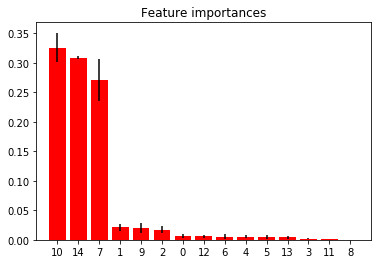

In [9]:
# Check feature importance
X_train = dt_train.drop('Fall',axis=1)
y_train = dt_train.Fall

forest = ExtraTreesClassifier(n_estimators=(X_train.shape[1]),random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [10]:
# First split data to input and output
X_test = dt_test.drop('Fall',axis=1)
y_test = dt_test.Fall
model = tree.DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.8522460331255742

In [11]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,153921,24962
True Fall,4789,17683


In [12]:
roc_auc_score(y_test,y_predict)

0.8236733141642089

In [13]:
graph = Source(tree.export_graphviz(model, out_file=None
   , feature_names=X_train.columns, class_names=['No Fall', 'Fall'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH